### 1. Reading in James' simulation data using Pandas

In [1]:
import pandas as pd

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'

df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)

### 2. Cleaning and reshaping data

In [2]:
import numpy as np

N = len(df_vel.T)-1 # number of nodes in the enviroment

# remove timestep column
vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1].copy() # use copy to avoid modifcation warning
idle_data[idle_data < 0] = np.nan # set negative idle values to NaN for later removal
vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

# combine datasets 
df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan) # set all inf values to NaN for later removal

# Drop rows with NaN values
df = df.dropna()

# attack length threshold to determine attack success and update to binary classification:
threshold = 50
for col in range(N*3,N*4):
    df.iloc[:, col] = (df.iloc[:, col] >= threshold).astype(int)

# convert data to array
dataset = df.to_numpy()

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
trainX, trainY, testX, testY = dataset[0:train_size,0:-N], dataset[0:train_size,N*3:N*4],dataset[train_size:len(dataset),0:-N], dataset[train_size:len(dataset),N*3:N*4] 
#split is appropriate as it trains on the first set of timestep values

# reshape data to appropriate format as (timestep, number of nodes, number of features)
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[-1]//3,3))
testX = np.reshape(testX, (testX.shape[0],testX.shape[-1]//3,3))

### 3. Create adjacency matrix for data's respective enviroment

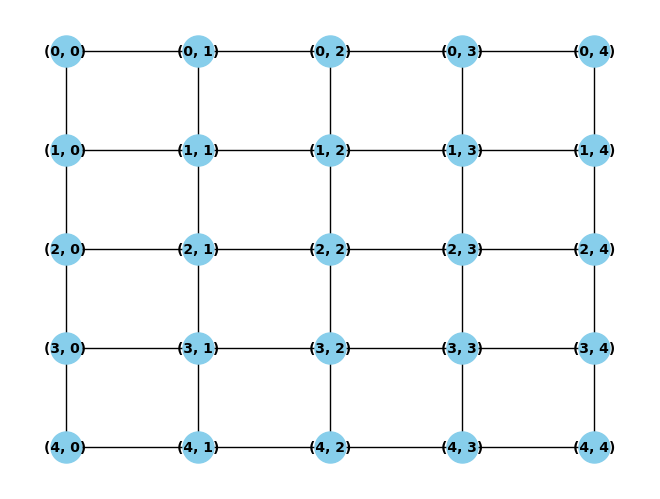

In [3]:
import networkx as nx

# Create node mappings
G = nx.grid_2d_graph(5, 5)

# convert to array
adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = adjacency_matrix.toarray()

# reshape to work with GNN and timeseries data
adjacency_matrix_train = np.repeat(adjacency_matrix[np.newaxis, :, :], train_size, axis=0)
adjacency_matrix_test = np.repeat(adjacency_matrix[np.newaxis, :, :], test_size, axis=0)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Visualise the enviroment for verification
#------------------------------------------------------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Plot the graph
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

plt.axis('off')
plt.show()

### 4. Compile and fit model

In [5]:
import tensorflow as tf
from Intruder_functionality import machine_learning as ml
import random

data_shape = (trainX.shape[1], trainX.shape[-1])
adjacency_shape = adjacency_matrix_train.shape[1:]

model = ml.ML_Intruder(data_shape, adjacency_shape)

# Compile the model
model.compile()

# Define the window size and threshold
window_size = 10
threshold = 0.99  # Example threshold

list_of_attacked_nodes = []
attack_outcomes = []
timestep = []

# Training loop
for i in range(window_size, trainX.shape[0]-1):

    print(i) # for initial visualisation of training progression

    # Get the most recent window of data
    window_data = trainX[i-window_size:i,:,:]

    # Get the corresponding label
    label = trainY[i-window_size:i,:]

    # Train on the window data
    model.train_on_batch(window_data, label)

    # Set replay buffer as all sequential data so far
    replay_buffer = trainX[0:i,:,:]
    replay_buffer_label = trainY[0:i,:]

    # Sample a batch from the replay buffer
    batch_size = min(len(replay_buffer), 32)  # Example batch size

    # Sample random indices from the replay buffer
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)

    # Extract the batch samples and labels using the sampled indices
    replay_batch = replay_buffer[indices]
    replay_batch_labels = replay_buffer_label[indices]

    # Convert the batch to arrays
    replay_batch_array = np.array(replay_batch)
    replay_batch_labels_array = np.array(replay_batch_labels)

    # Train on the replay batch
    model.train_on_batch(replay_batch_array, replay_batch_labels_array)

    # get the next timestep data
    attack_window = trainX[i+1,:,:]
    attack_window = attack_window[np.newaxis, ...]  # Add batch dimension
    attack_label = trainY[i+1,:]

    # Predict on the window data
    prediction = model.predict(attack_window)


    # Check the prediction against the threshold
    if (i>100) & (prediction.max() >= threshold):
        max_index = prediction.argmax()
        print(f"Threshold reached with prediction: {prediction.max()} at timestep: {i}")
        print(f"Attack succesful if value is 1, with the value being: {attack_label[max_index]} at timestep: {i}")
        list_of_attacked_nodes.append(max_index+1)
        attack_outcomes.append(attack_label[max_index])
        timestep.append(i+1)

    if i == 2500:
        break






10
1/1 [==============================] - 0s 96ms/step
11
1/1 [==============================] - 0s 24ms/step
12
1/1 [==============================] - 0s 22ms/step
13
1/1 [==============================] - 0s 24ms/step
14
1/1 [==============================] - 0s 23ms/step
15
1/1 [==============================] - 0s 25ms/step
16
1/1 [==============================] - 0s 27ms/step
17
1/1 [==============================] - 0s 22ms/step
18
1/1 [==============================] - 0s 22ms/step
19
1/1 [==============================] - 0s 23ms/step
20
1/1 [==============================] - 0s 29ms/step
21
1/1 [==============================] - 0s 22ms/step
22
1/1 [==============================] - 0s 23ms/step
23
1/1 [==============================] - 0s 24ms/step
24
1/1 [==============================] - 0s 23ms/step
25
1/1 [==============================] - 0s 23ms/step
26
1/1 [==============================] - 0s 22ms/step
27
1/1 [==============================] - 0s 25ms/step
28
1/1 [==

### 5. Overall Performance Review 

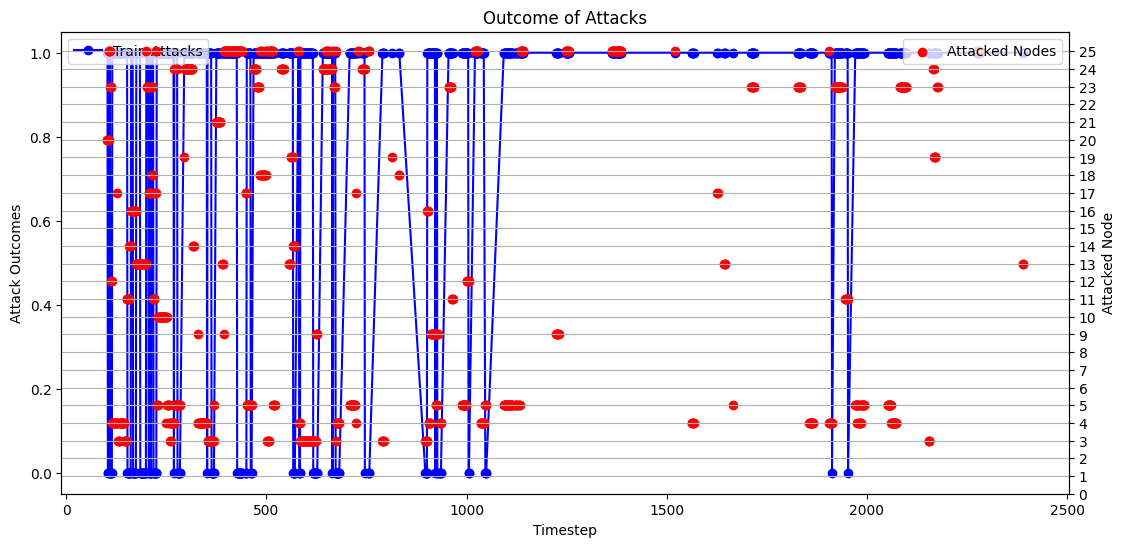

In [6]:
# import matplotlib.pyplot as plt


# plt.figure(figsize=(10, 6))
# plt.plot(timestep, attack_outcomes, label='Train Attacks', marker='o')

# plt.title('Outcome of attacks')
# plt.xlabel('timestep')
# plt.ylabel('label')
# plt.legend()
# plt.grid(True)
# # plt.savefig("decay_learning_rate_0.001_success_fail.png")


import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(13, 6))

# Plot the first data on the left y-axis
ax1.plot(timestep, attack_outcomes, label='Train Attacks', marker='o', color='blue')
ax1.set_ylabel('Attack Outcomes')

# Create a twin axis on the right
ax2 = ax1.twinx()

# Plot the second data on the right y-axis
ax2.scatter(timestep, list_of_attacked_nodes, label='Attacked Nodes', marker='o', color='red')
ax2.set_ylabel('Attacked Node')

ax2.set_yticks(np.arange(0, N+1, 1))

# Set titles, labels, and legends
ax1.set_title('Outcome of Attacks')
ax1.set_xlabel('Timestep')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the grid
ax2.grid(True)

# Save the plot if needed
plt.savefig("first_replay_buffer_setup.png")

# Show the plot
plt.show()


In [ ]:
import numpy as np


unique_values, counts = np.unique(attack_outcomes, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print("Value:", value, "Count:", count)

Value: 0.0 Count: 414
Value: 1.0 Count: 695
